In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report

In [2]:
class IVFDataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        if y is None:
            self.y = y
        else:
            self.y = torch.FloatTensor(y)
        self.x = torch.FloatTensor(x)

    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [3]:
class DNN_Regression(nn.Module):
    def __init__(self, input_dim):
        super(DNN_Regression, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [4]:
train_loss=[] 
val_loss=[]

def trainer(train_loader, valid_loader, model, config, device):
    
    # TODO try differnet criterion or optimizer 
    criterion = nn.MSELoss(reduction='mean')
    optimizer = torch.optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=0.9)
    writer = SummaryWriter()
    
    if not os.path.isdir('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models'):
        os.mkdir('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models') # Create directory of saving models.
    
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    
    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)

        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            loss = criterion(pred, y)
            
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})

        mean_train_loss = sum(loss_record)/len(loss_record)
        train_loss.append(mean_train_loss)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
                

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        val_loss.append(mean_valid_loss)
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [5]:
device = 'cpu'

config = {
    'seed': 1322,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-4,              
    'early_stop': 20,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': '/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models/model2.ckpt'  # Your model will be saved here.
}

In [6]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [7]:
same_seed(config['seed'])

In [8]:
train_x = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/train_x.csv')
train_y = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/train_y.csv')
test_x = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/test_x.csv')
test_y = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/test_y.csv')

In [9]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.10, random_state=42)

In [10]:
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(112338, 21) (112338, 1)
(12482, 21) (12482, 1)
(31205, 21) (31205, 1)


In [11]:
train_x = train_x.to_numpy()
train_y = train_y.to_numpy().ravel()
valid_x = valid_x.to_numpy()
valid_y = valid_y.to_numpy().ravel()
test_x  = test_x.to_numpy()
test_y = test_y.to_numpy().ravel()

In [12]:
train_dataset = IVFDataset(train_x, train_y)
valid_dataset = IVFDataset(valid_x, valid_y)
test_dataset = IVFDataset(test_x)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

In [14]:
train_loss = []
val_loss = []
model = DNN_Regression(input_dim=train_x.shape[1]).to(device)

In [15]:
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 224.49it/s, loss=0.115]


Epoch [1/500]: Train loss: 0.1286, Valid loss: 0.1206
Saving model with loss 0.121...


Epoch [2/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 252.67it/s, loss=0.139]


Epoch [2/500]: Train loss: 0.1217, Valid loss: 0.1187
Saving model with loss 0.119...


Epoch [3/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 285.22it/s, loss=0.107]


Epoch [3/500]: Train loss: 0.1196, Valid loss: 0.1164
Saving model with loss 0.116...


Epoch [4/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 272.54it/s, loss=0.104]


Epoch [4/500]: Train loss: 0.1174, Valid loss: 0.1144
Saving model with loss 0.114...


Epoch [5/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 271.63it/s, loss=0.129]


Epoch [5/500]: Train loss: 0.1151, Valid loss: 0.1118
Saving model with loss 0.112...


Epoch [6/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 251.06it/s, loss=0.123]


Epoch [6/500]: Train loss: 0.1129, Valid loss: 0.1098
Saving model with loss 0.110...


Epoch [7/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 255.77it/s, loss=0.159]


Epoch [7/500]: Train loss: 0.1106, Valid loss: 0.1075
Saving model with loss 0.107...


Epoch [8/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 275.92it/s, loss=0.0947]


Epoch [8/500]: Train loss: 0.1084, Valid loss: 0.1053
Saving model with loss 0.105...


Epoch [9/500]: 100%|███████████████████████████████████████████████████████| 439/439 [00:01<00:00, 244.98it/s, loss=0.149]


Epoch [9/500]: Train loss: 0.1063, Valid loss: 0.1033
Saving model with loss 0.103...


Epoch [10/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 264.07it/s, loss=0.119]


Epoch [10/500]: Train loss: 0.1042, Valid loss: 0.1004
Saving model with loss 0.100...


Epoch [11/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 278.84it/s, loss=0.0947]


Epoch [11/500]: Train loss: 0.1004, Valid loss: 0.0974
Saving model with loss 0.097...


Epoch [12/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 259.30it/s, loss=0.108]


Epoch [12/500]: Train loss: 0.0978, Valid loss: 0.0947
Saving model with loss 0.095...


Epoch [13/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 281.00it/s, loss=0.0842]


Epoch [13/500]: Train loss: 0.0955, Valid loss: 0.0926
Saving model with loss 0.093...


Epoch [14/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 259.03it/s, loss=0.0759]


Epoch [14/500]: Train loss: 0.0933, Valid loss: 0.0903
Saving model with loss 0.090...


Epoch [15/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 250.48it/s, loss=0.0637]


Epoch [15/500]: Train loss: 0.0911, Valid loss: 0.0882
Saving model with loss 0.088...


Epoch [16/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 261.99it/s, loss=0.085]


Epoch [16/500]: Train loss: 0.0889, Valid loss: 0.0858
Saving model with loss 0.086...


Epoch [17/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 242.50it/s, loss=0.0732]


Epoch [17/500]: Train loss: 0.0866, Valid loss: 0.0836
Saving model with loss 0.084...


Epoch [18/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 271.65it/s, loss=0.065]


Epoch [18/500]: Train loss: 0.0841, Valid loss: 0.0811
Saving model with loss 0.081...


Epoch [19/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 279.18it/s, loss=0.0699]


Epoch [19/500]: Train loss: 0.0816, Valid loss: 0.0786
Saving model with loss 0.079...


Epoch [20/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 269.09it/s, loss=0.0697]


Epoch [20/500]: Train loss: 0.0789, Valid loss: 0.0760
Saving model with loss 0.076...


Epoch [21/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 272.61it/s, loss=0.0871]


Epoch [21/500]: Train loss: 0.0762, Valid loss: 0.0730
Saving model with loss 0.073...


Epoch [22/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 265.21it/s, loss=0.0678]


Epoch [22/500]: Train loss: 0.0732, Valid loss: 0.0702
Saving model with loss 0.070...


Epoch [23/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 268.14it/s, loss=0.0682]


Epoch [23/500]: Train loss: 0.0703, Valid loss: 0.0672
Saving model with loss 0.067...


Epoch [24/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 273.64it/s, loss=0.0871]


Epoch [24/500]: Train loss: 0.0672, Valid loss: 0.0643
Saving model with loss 0.064...


Epoch [25/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 233.20it/s, loss=0.0488]


Epoch [25/500]: Train loss: 0.0640, Valid loss: 0.0611
Saving model with loss 0.061...


Epoch [26/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 276.80it/s, loss=0.111]


Epoch [26/500]: Train loss: 0.0609, Valid loss: 0.0580
Saving model with loss 0.058...


Epoch [27/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 273.81it/s, loss=0.0541]


Epoch [27/500]: Train loss: 0.0577, Valid loss: 0.0550
Saving model with loss 0.055...


Epoch [28/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 262.99it/s, loss=0.0437]


Epoch [28/500]: Train loss: 0.0547, Valid loss: 0.0521
Saving model with loss 0.052...


Epoch [29/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 278.06it/s, loss=0.0506]


Epoch [29/500]: Train loss: 0.0519, Valid loss: 0.0493
Saving model with loss 0.049...


Epoch [30/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 274.67it/s, loss=0.0448]


Epoch [30/500]: Train loss: 0.0493, Valid loss: 0.0468
Saving model with loss 0.047...


Epoch [31/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.41it/s, loss=0.0433]


Epoch [31/500]: Train loss: 0.0469, Valid loss: 0.0448
Saving model with loss 0.045...


Epoch [32/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 283.76it/s, loss=0.0431]


Epoch [32/500]: Train loss: 0.0449, Valid loss: 0.0429
Saving model with loss 0.043...


Epoch [33/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 249.37it/s, loss=0.0419]


Epoch [33/500]: Train loss: 0.0432, Valid loss: 0.0417
Saving model with loss 0.042...


Epoch [34/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 274.93it/s, loss=0.0532]


Epoch [34/500]: Train loss: 0.0418, Valid loss: 0.0403
Saving model with loss 0.040...


Epoch [35/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 253.16it/s, loss=0.0407]


Epoch [35/500]: Train loss: 0.0407, Valid loss: 0.0394
Saving model with loss 0.039...


Epoch [36/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 249.54it/s, loss=0.0313]


Epoch [36/500]: Train loss: 0.0399, Valid loss: 0.0393
Saving model with loss 0.039...


Epoch [37/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 271.15it/s, loss=0.0472]


Epoch [37/500]: Train loss: 0.0392, Valid loss: 0.0390
Saving model with loss 0.039...


Epoch [38/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 257.95it/s, loss=0.0422]


Epoch [38/500]: Train loss: 0.0388, Valid loss: 0.0380
Saving model with loss 0.038...


Epoch [39/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 252.93it/s, loss=0.0433]


Epoch [39/500]: Train loss: 0.0384, Valid loss: 0.0376
Saving model with loss 0.038...


Epoch [40/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 287.55it/s, loss=0.0538]


Epoch [40/500]: Train loss: 0.0382, Valid loss: 0.0374
Saving model with loss 0.037...


Epoch [41/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 257.44it/s, loss=0.0342]


Epoch [41/500]: Train loss: 0.0380, Valid loss: 0.0373
Saving model with loss 0.037...


Epoch [42/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 283.61it/s, loss=0.0504]


Epoch [42/500]: Train loss: 0.0379, Valid loss: 0.0374


Epoch [43/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 267.77it/s, loss=0.0608]


Epoch [43/500]: Train loss: 0.0378, Valid loss: 0.0372
Saving model with loss 0.037...


Epoch [44/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 268.27it/s, loss=0.0384]


Epoch [44/500]: Train loss: 0.0377, Valid loss: 0.0372


Epoch [45/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 275.57it/s, loss=0.0513]


Epoch [45/500]: Train loss: 0.0377, Valid loss: 0.0374


Epoch [46/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 231.43it/s, loss=0.0262]


Epoch [46/500]: Train loss: 0.0376, Valid loss: 0.0371
Saving model with loss 0.037...


Epoch [47/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 283.43it/s, loss=0.0325]


Epoch [47/500]: Train loss: 0.0376, Valid loss: 0.0370
Saving model with loss 0.037...


Epoch [48/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 304.03it/s, loss=0.0272]


Epoch [48/500]: Train loss: 0.0376, Valid loss: 0.0373


Epoch [49/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.57it/s, loss=0.0411]


Epoch [49/500]: Train loss: 0.0375, Valid loss: 0.0373


Epoch [50/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 292.22it/s, loss=0.0484]


Epoch [50/500]: Train loss: 0.0375, Valid loss: 0.0374


Epoch [51/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 264.13it/s, loss=0.0279]


Epoch [51/500]: Train loss: 0.0375, Valid loss: 0.0372


Epoch [52/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 256.22it/s, loss=0.0166]


Epoch [52/500]: Train loss: 0.0375, Valid loss: 0.0369
Saving model with loss 0.037...


Epoch [53/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 264.40it/s, loss=0.0397]


Epoch [53/500]: Train loss: 0.0375, Valid loss: 0.0370


Epoch [54/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 257.75it/s, loss=0.026]


Epoch [54/500]: Train loss: 0.0375, Valid loss: 0.0372


Epoch [55/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 265.25it/s, loss=0.0323]


Epoch [55/500]: Train loss: 0.0375, Valid loss: 0.0370


Epoch [56/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 292.70it/s, loss=0.0457]


Epoch [56/500]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [57/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 263.60it/s, loss=0.0367]


Epoch [57/500]: Train loss: 0.0374, Valid loss: 0.0369
Saving model with loss 0.037...


Epoch [58/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 267.37it/s, loss=0.0372]


Epoch [58/500]: Train loss: 0.0374, Valid loss: 0.0373


Epoch [59/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 275.08it/s, loss=0.0462]


Epoch [59/500]: Train loss: 0.0374, Valid loss: 0.0372


Epoch [60/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 263.67it/s, loss=0.0276]


Epoch [60/500]: Train loss: 0.0374, Valid loss: 0.0372


Epoch [61/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 280.71it/s, loss=0.0301]


Epoch [61/500]: Train loss: 0.0374, Valid loss: 0.0368
Saving model with loss 0.037...


Epoch [62/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 260.50it/s, loss=0.0356]


Epoch [62/500]: Train loss: 0.0374, Valid loss: 0.0374


Epoch [63/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 298.48it/s, loss=0.0317]


Epoch [63/500]: Train loss: 0.0374, Valid loss: 0.0378


Epoch [64/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 276.79it/s, loss=0.0424]


Epoch [64/500]: Train loss: 0.0374, Valid loss: 0.0372


Epoch [65/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 259.03it/s, loss=0.0275]


Epoch [65/500]: Train loss: 0.0375, Valid loss: 0.0370


Epoch [66/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 282.98it/s, loss=0.0234]


Epoch [66/500]: Train loss: 0.0374, Valid loss: 0.0369


Epoch [67/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 261.95it/s, loss=0.0308]


Epoch [67/500]: Train loss: 0.0374, Valid loss: 0.0370


Epoch [68/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 274.38it/s, loss=0.0472]


Epoch [68/500]: Train loss: 0.0374, Valid loss: 0.0369


Epoch [69/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 277.26it/s, loss=0.054]


Epoch [69/500]: Train loss: 0.0374, Valid loss: 0.0369


Epoch [70/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 248.50it/s, loss=0.0493]


Epoch [70/500]: Train loss: 0.0374, Valid loss: 0.0369


Epoch [71/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 284.66it/s, loss=0.0378]


Epoch [71/500]: Train loss: 0.0373, Valid loss: 0.0373


Epoch [72/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 275.75it/s, loss=0.0362]


Epoch [72/500]: Train loss: 0.0374, Valid loss: 0.0368
Saving model with loss 0.037...


Epoch [73/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 256.51it/s, loss=0.0331]


Epoch [73/500]: Train loss: 0.0374, Valid loss: 0.0368


Epoch [74/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 261.74it/s, loss=0.0377]


Epoch [74/500]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [75/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 266.73it/s, loss=0.0295]


Epoch [75/500]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [76/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 273.38it/s, loss=0.0447]


Epoch [76/500]: Train loss: 0.0373, Valid loss: 0.0372


Epoch [77/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 277.87it/s, loss=0.0472]


Epoch [77/500]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [78/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 263.53it/s, loss=0.0194]


Epoch [78/500]: Train loss: 0.0373, Valid loss: 0.0373


Epoch [79/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 283.66it/s, loss=0.0323]


Epoch [79/500]: Train loss: 0.0373, Valid loss: 0.0369


Epoch [80/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 268.04it/s, loss=0.0341]


Epoch [80/500]: Train loss: 0.0372, Valid loss: 0.0368
Saving model with loss 0.037...


Epoch [81/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 275.20it/s, loss=0.0324]


Epoch [81/500]: Train loss: 0.0373, Valid loss: 0.0367
Saving model with loss 0.037...


Epoch [82/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 273.61it/s, loss=0.0337]


Epoch [82/500]: Train loss: 0.0372, Valid loss: 0.0368


Epoch [83/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 257.65it/s, loss=0.0275]


Epoch [83/500]: Train loss: 0.0373, Valid loss: 0.0370


Epoch [84/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 258.48it/s, loss=0.0306]


Epoch [84/500]: Train loss: 0.0372, Valid loss: 0.0368


Epoch [85/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 283.82it/s, loss=0.0249]


Epoch [85/500]: Train loss: 0.0372, Valid loss: 0.0369


Epoch [86/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 264.93it/s, loss=0.0425]


Epoch [86/500]: Train loss: 0.0372, Valid loss: 0.0374


Epoch [87/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 270.82it/s, loss=0.022]


Epoch [87/500]: Train loss: 0.0372, Valid loss: 0.0370


Epoch [88/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 263.75it/s, loss=0.0365]


Epoch [88/500]: Train loss: 0.0372, Valid loss: 0.0367
Saving model with loss 0.037...


Epoch [89/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 261.85it/s, loss=0.0642]


Epoch [89/500]: Train loss: 0.0372, Valid loss: 0.0368


Epoch [90/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 266.76it/s, loss=0.0355]


Epoch [90/500]: Train loss: 0.0372, Valid loss: 0.0370


Epoch [91/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 251.40it/s, loss=0.0506]


Epoch [91/500]: Train loss: 0.0372, Valid loss: 0.0368


Epoch [92/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 268.04it/s, loss=0.046]


Epoch [92/500]: Train loss: 0.0372, Valid loss: 0.0370


Epoch [93/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 267.53it/s, loss=0.041]


Epoch [93/500]: Train loss: 0.0372, Valid loss: 0.0368


Epoch [94/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 258.28it/s, loss=0.0257]


Epoch [94/500]: Train loss: 0.0372, Valid loss: 0.0371


Epoch [95/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 286.80it/s, loss=0.0239]


Epoch [95/500]: Train loss: 0.0372, Valid loss: 0.0367
Saving model with loss 0.037...


Epoch [96/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 259.93it/s, loss=0.0326]


Epoch [96/500]: Train loss: 0.0372, Valid loss: 0.0370


Epoch [97/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 261.04it/s, loss=0.0371]


Epoch [97/500]: Train loss: 0.0371, Valid loss: 0.0371


Epoch [98/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 283.14it/s, loss=0.0361]


Epoch [98/500]: Train loss: 0.0372, Valid loss: 0.0368


Epoch [99/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 258.23it/s, loss=0.0402]


Epoch [99/500]: Train loss: 0.0371, Valid loss: 0.0367
Saving model with loss 0.037...


Epoch [100/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 267.98it/s, loss=0.0382]


Epoch [100/500]: Train loss: 0.0372, Valid loss: 0.0368


Epoch [101/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 273.66it/s, loss=0.0342]


Epoch [101/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [102/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 262.41it/s, loss=0.0456]


Epoch [102/500]: Train loss: 0.0372, Valid loss: 0.0368


Epoch [103/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 268.53it/s, loss=0.0388]


Epoch [103/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [104/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 267.34it/s, loss=0.0347]


Epoch [104/500]: Train loss: 0.0371, Valid loss: 0.0368


Epoch [105/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 261.95it/s, loss=0.0324]


Epoch [105/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [106/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 282.45it/s, loss=0.0333]


Epoch [106/500]: Train loss: 0.0372, Valid loss: 0.0369


Epoch [107/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 246.96it/s, loss=0.0489]


Epoch [107/500]: Train loss: 0.0372, Valid loss: 0.0368


Epoch [108/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 283.39it/s, loss=0.0391]


Epoch [108/500]: Train loss: 0.0371, Valid loss: 0.0366
Saving model with loss 0.037...


Epoch [109/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 277.83it/s, loss=0.0529]


Epoch [109/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [110/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 268.81it/s, loss=0.0605]


Epoch [110/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [111/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 288.78it/s, loss=0.0381]


Epoch [111/500]: Train loss: 0.0371, Valid loss: 0.0370


Epoch [112/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 255.73it/s, loss=0.0329]


Epoch [112/500]: Train loss: 0.0371, Valid loss: 0.0370


Epoch [113/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 265.81it/s, loss=0.0285]


Epoch [113/500]: Train loss: 0.0371, Valid loss: 0.0369


Epoch [114/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 291.62it/s, loss=0.0379]


Epoch [114/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [115/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 256.23it/s, loss=0.0366]


Epoch [115/500]: Train loss: 0.0371, Valid loss: 0.0366
Saving model with loss 0.037...


Epoch [116/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 275.84it/s, loss=0.0318]


Epoch [116/500]: Train loss: 0.0371, Valid loss: 0.0368


Epoch [117/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 271.19it/s, loss=0.0266]


Epoch [117/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [118/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 247.48it/s, loss=0.0443]


Epoch [118/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [119/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 275.10it/s, loss=0.0311]


Epoch [119/500]: Train loss: 0.0370, Valid loss: 0.0369


Epoch [120/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 270.42it/s, loss=0.0311]


Epoch [120/500]: Train loss: 0.0371, Valid loss: 0.0366
Saving model with loss 0.037...


Epoch [121/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 257.50it/s, loss=0.0282]


Epoch [121/500]: Train loss: 0.0371, Valid loss: 0.0368


Epoch [122/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 276.41it/s, loss=0.0378]


Epoch [122/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [123/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 252.59it/s, loss=0.0384]


Epoch [123/500]: Train loss: 0.0371, Valid loss: 0.0368


Epoch [124/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 273.65it/s, loss=0.0425]


Epoch [124/500]: Train loss: 0.0371, Valid loss: 0.0371


Epoch [125/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 257.31it/s, loss=0.0252]


Epoch [125/500]: Train loss: 0.0370, Valid loss: 0.0366


Epoch [126/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 265.00it/s, loss=0.0456]


Epoch [126/500]: Train loss: 0.0370, Valid loss: 0.0367


Epoch [127/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 291.35it/s, loss=0.0377]


Epoch [127/500]: Train loss: 0.0370, Valid loss: 0.0366


Epoch [128/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 276.01it/s, loss=0.0393]


Epoch [128/500]: Train loss: 0.0371, Valid loss: 0.0368


Epoch [129/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 265.54it/s, loss=0.03]


Epoch [129/500]: Train loss: 0.0371, Valid loss: 0.0370


Epoch [130/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 286.16it/s, loss=0.0463]


Epoch [130/500]: Train loss: 0.0370, Valid loss: 0.0368


Epoch [131/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 261.01it/s, loss=0.036]


Epoch [131/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [132/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 294.27it/s, loss=0.0453]


Epoch [132/500]: Train loss: 0.0370, Valid loss: 0.0367


Epoch [133/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 262.37it/s, loss=0.0225]


Epoch [133/500]: Train loss: 0.0370, Valid loss: 0.0367


Epoch [134/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 263.36it/s, loss=0.0288]


Epoch [134/500]: Train loss: 0.0370, Valid loss: 0.0367


Epoch [135/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 277.07it/s, loss=0.0374]


Epoch [135/500]: Train loss: 0.0371, Valid loss: 0.0366


Epoch [136/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 269.20it/s, loss=0.0326]


Epoch [136/500]: Train loss: 0.0371, Valid loss: 0.0367


Epoch [137/500]: 100%|█████████████████████████████████████████████████████| 439/439 [00:01<00:00, 266.99it/s, loss=0.028]


Epoch [137/500]: Train loss: 0.0370, Valid loss: 0.0366


Epoch [138/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 279.75it/s, loss=0.0451]


Epoch [138/500]: Train loss: 0.0370, Valid loss: 0.0367


Epoch [139/500]: 100%|██████████████████████████████████████████████████████| 439/439 [00:01<00:00, 265.01it/s, loss=0.04]


Epoch [139/500]: Train loss: 0.0371, Valid loss: 0.0369


Epoch [140/500]: 100%|████████████████████████████████████████████████████| 439/439 [00:01<00:00, 284.40it/s, loss=0.0333]


Epoch [140/500]: Train loss: 0.0370, Valid loss: 0.0367

Model is not improving, so we halt the training session.


In [16]:
%reload_ext tensorboard
%tensorboard --logdir=./runs/

Reusing TensorBoard on port 6006 (pid 21791), started 0:34:58 ago. (Use '!kill 21791' to kill it.)

In [17]:
len(train_loss)


140

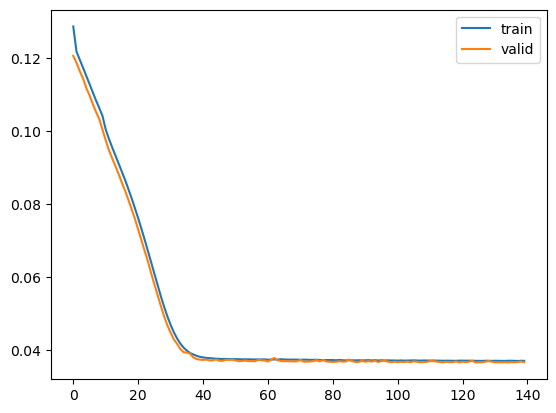

In [18]:
from matplotlib import pyplot
pyplot.plot(train_loss, label='train')
pyplot.plot(val_loss, label='valid')
pyplot.legend()
pyplot.show()

In [15]:
model = DNN_Regression(input_dim=train_x.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 624.36it/s]


In [16]:
preds

array([ 0.00358723, -0.00641644, -0.00489882, ...,  0.00914982,
       -0.00800996, -0.00526546], dtype=float32)

In [21]:
from sklearn.metrics import mean_squared_error

mean_squared_error(preds, test_y)

0.03701254858144049

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_train_x = pca.fit_transform(train_x)

pca_test_x = pca.transform(test_x)

df = pd.DataFrame(pca_test_x)
df['y'] = preds
df['groundTrue'] = test_y
df


,0,y,groundTrue
0,2.518758,0.003587,0
1,2.633924,-0.006416,0
2,5.037992,-0.004899,0
3,7.563413,0.022690,0
4,2.510550,0.015173,0
...,...,...,...
31200,-7.454380,-0.006662,0
31201,-7.409502,0.645255,1
31202,5.092651,0.009150,0
31203,2.531582,-0.008010,0


/tmp/ipykernel_32046/920653628.py:5: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.scatterplot(


<AxesSubplot:xlabel='0', ylabel='y'>

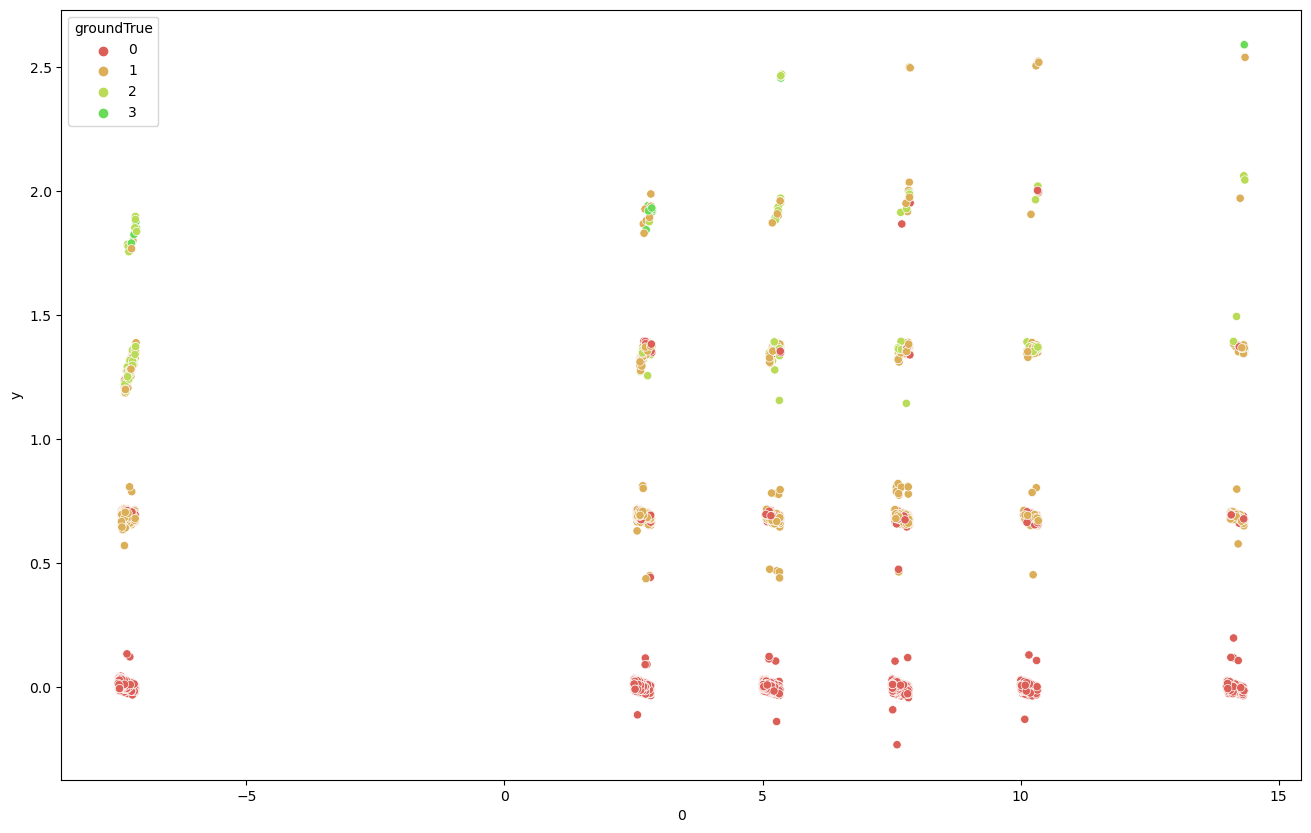

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y='y',
    hue="groundTrue",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=1
)

In [17]:

hard_result = np.round(preds)

print(classification_report(test_y, hard_result))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     27490
           1       0.72      0.99      0.83      3509
           2       0.40      0.18      0.25       192
           3       0.20      0.07      0.11        14

    accuracy                           0.96     31205
   macro avg       0.58      0.55      0.54     31205
weighted avg       0.96      0.96      0.96     31205

